# Library Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from collections import defaultdict
import geopy as gp
from geopy.geocoders import Nominatim
import time
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import copy
import statsmodels.api as sm
import prophet
import googlemaps
from datetime import datetime

Importing plotly failed. Interactive plots will not work.


# Data Import

In [2]:
# read parking ticket data from integrated csv file
df = pd.read_csv('database.csv')

# convert date into datetime format
df.set_index(pd.to_datetime(df['date_issue'], format='%Y-%m-%d'), inplace=True)

df.head()

/var/folders/vk/ttmk8bs93hl7gd4q5jlxqm9m0000gn/T/ipykernel_47160/2519740444.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('database.csv')


,citation_id,date_issue,date_creation,location,sector1,vio_code,vio_desc,vio_fine
date_issue,,,,,,,,
2012-06-30,54572469,2012-06-30,2012-06-30 10:48:42,1100 8TH AV,CSD (I) PARKING ENF,86.14 SDMC,EXPIRED METER,42.5
2012-06-30,54564665,2012-06-30,2012-06-30 10:53:45,8830 VILLA LA JOLLA DR,CSD (I) PARKING ENF,86.08.1 SDMC,WHEEL CRAMPING-HILL,59.5
2012-06-30,54572499,2012-06-30,2012-06-30 12:54:37,500 JUNIPER ST,CSD (I) PARKING ENF,86.14 SDMC,EXPIRED METER,42.5
2012-06-30,53405531,2012-06-30,2012-06-30 16:55:39,DEANZA BOAT LAUNCH RAMP 3500 MISSION BAY DR,CSD (W) PARK RANGERS,86.09(E) SDMC,VIOLATION OF SIGNS (SDMC),52.5
2012-06-30,54573748,2012-06-30,2012-06-30 16:50:15,747 EMERALD ST,CSD (I) PARKING ENF,86.09(E) SDMC,VIOLATION OF SIGNS (SDMC),52.5


In [3]:
# read population data from csv file
population = pd.read_csv("./DataSource/population_cities_2010_2022.csv", index_col = "City")
population.head()

,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
City,,,,,,,,,,,,,
Adelanto city,"31,661","31,864","31,088","31,206","32,522","32,961","33,249","33,952","34,070","34,049","38,128","38,436","38,783"
Agoura Hills city,"20,338","20,475","20,544","20,591","20,648","20,740","20,665","20,572","20,411","20,222","20,227","19,802","19,464"
Alameda city,"73,946","74,692","75,637","76,479","77,509","78,459","79,091","79,037","78,344","77,624","78,044","76,246","76,040"
Albany city,"18,539","18,720","18,957","19,187","19,434","19,662","19,713","20,076","19,885","19,696","20,225","19,823","19,415"
Alhambra city,"83,160","83,594","84,120","84,337","84,786","84,843","85,221","84,878","84,373","83,750","82,657","81,168","80,259"


In [4]:
# read parking meters data from csv file
parking_meters = pd.read_csv("./DataSource/parking_meters_loc_datasd.csv")

# convert date into datetime format
parking_meters.set_index(pd.to_datetime(parking_meters['date_inventory'], format='%Y-%m-%d'), inplace=True)

parking_meters.head()

,zone,area,sub_area,pole,config_id,config_name,date_inventory,lat,lng,sapid
date_inventory,,,,,,,,,,
2021-01-04,Downtown,Core,1000 FIRST AVE,1-1004,49382,Sunday Mode,2021-01-04,32.715904,-117.163929,SS-000031
2018-11-11,Downtown,Core - Columbia,1000 FIRST AVE,1-1004,9000,2 Hour Max $1.25 HR 8am-6pm Mon-Sat (NFC),2018-11-11,32.715904,-117.163929,SS-000031
2021-01-04,Downtown,Core,1000 FIRST AVE,1-1006,49382,Sunday Mode,2021-01-04,32.716037,-117.163930,SS-000031
2018-11-11,Downtown,Core - Columbia,1000 FIRST AVE,1-1006,9000,2 Hour Max $1.25 HR 8am-6pm Mon-Sat (NFC),2018-11-11,32.716037,-117.163930,SS-000031
2021-01-04,Downtown,Core,1000 FIRST AVE,1-1008,49382,Sunday Mode,2021-01-04,32.716169,-117.163931,SS-000031


# Periodic Reshape

In [5]:
# get daily, monthly and yearly amount of the parking tickets
issue_daily, issue_monthly, issue_yearly = defaultdict(list), defaultdict(list), defaultdict(list)
for index, row in df.iterrows():
    issue_daily[index].append((row['vio_fine'], row['citation_id']))
    issue_monthly[(index.year, index.month)].append((row['vio_fine'], row['citation_id']))
    issue_yearly[index.year].append((row['vio_fine'], row['citation_id']))

issue_daily_amount, issue_daily_citation = defaultdict(int), defaultdict(float)
for date, issue in issue_daily.items():
    issue_daily_amount[date] = len(issue)
    issue_daily_citation[date] = sum([i[0] for i in issue])

issue_monthly_amount, issue_monthly_citation = defaultdict(int), defaultdict(float)
for date, issue in issue_monthly.items():
    issue_monthly_amount[date] = len(issue)
    issue_monthly_citation[date] = sum([i[0] for i in issue])

issue_yearly_amount, issue_yearly_citation = defaultdict(int), defaultdict(float)
for year, issue in issue_yearly.items():
    issue_yearly_amount[year] = len(issue)
    issue_yearly_citation[year] = sum([i[0] for i in issue])

# Rgression Between Frequency and Population

In [6]:
# get the population within San Diego
sd_cities = ["San Diego city","Chula Vista city","Oceanside city","Escondido city","Carlsbad city","El Cajon city","Vista city","San Marcos city","Encinitas city","National City city"]

# filter non-sd data
for index, row in population.iterrows():
    if index not in sd_cities: population = population.drop(index)

# align the name format
for i in range(2010,2023):
    population[str(i)] = population[str(i)].str.replace(',', '').astype(float)

assert len(population) == len(sd_cities), 'Missing City Population'

In [7]:
# get the whole sd's population
population_whole_sd = [[sum(j for j in population[str(i)])] for i in range(2010,2023)]
assert len(population_whole_sd) == 13, 'Population Incomplete'

In [8]:
# set variables (x as the yearly ticket amount and y as the yearly population in San Diego)
x,y = [], []
for i in range(2012, 2023):
    y.append(issue_yearly_amount[i])
for i in range(2,len(population_whole_sd)):
    x.append(population_whole_sd[i])

assert len(x) == len(y), 'Incompatiable Variables'

p-value:[0.30053211 0.15861427]
R^2 Score: 0.20796179819139193


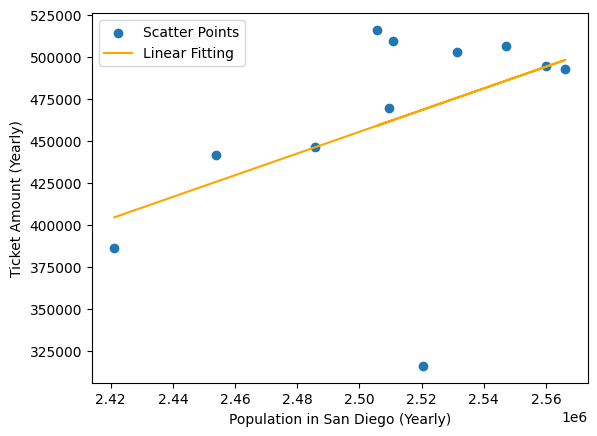

In [9]:
# correlation 2012-2022
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
y_pred = model.predict(x)

p_values = model.pvalues
print(f"p-value:{p_values}")

r2 = r2_score(y, y_pred)
print(f'R^2 Score: {r2}')

# Visualizing the linear regression line
plt.scatter([i[1] for i in x], y, label='Scatter Points')
plt.plot([i[1] for i in x], y_pred, color='orange', label='Linear Fitting')
plt.xlabel('Population in San Diego (Yearly)')
plt.ylabel('Ticket Amount (Yearly)')
plt.legend()
plt.show()

p-value:[0.01538938 0.00325623]
R^2 Score: 0.6817102534813443


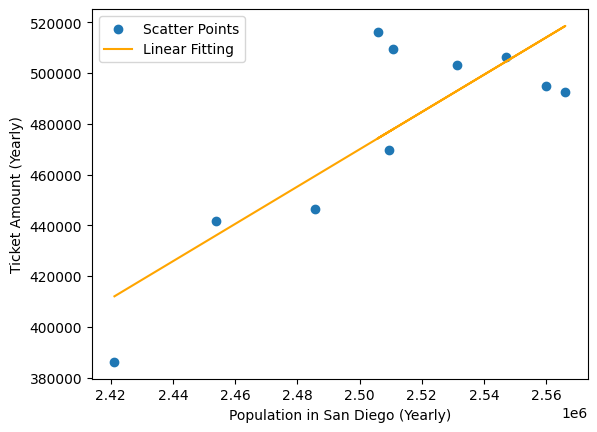

In [10]:
# correlation 2012-2022 excluding 2020
x2 = copy.deepcopy(list(x))
x2.pop(8)
y2 = copy.deepcopy(y)
y2.pop(8)

assert len(x2) == len(y2), 'Incompatiable Variables'

x2 = sm.add_constant(x2)
model2 = sm.OLS(y2, x2).fit()
y_pred2 = model2.predict(x2)

p_values2 = model2.pvalues
print(f"p-value:{p_values2}")

r22 = r2_score(y2, y_pred2)
print(f'R^2 Score: {r22}')

# Visualizing the linear regression line
plt.scatter([i[1] for i in x2], y2, label='Scatter Points')
plt.plot([i[1] for i in x2], y_pred2, color='orange', label='Linear Fitting')
plt.xlabel('Population in San Diego (Yearly)')
plt.ylabel('Ticket Amount (Yearly)')
plt.legend()
plt.show()

p-value:[0.00238929 0.00052793]
R^2 Score: 0.8827236968030256


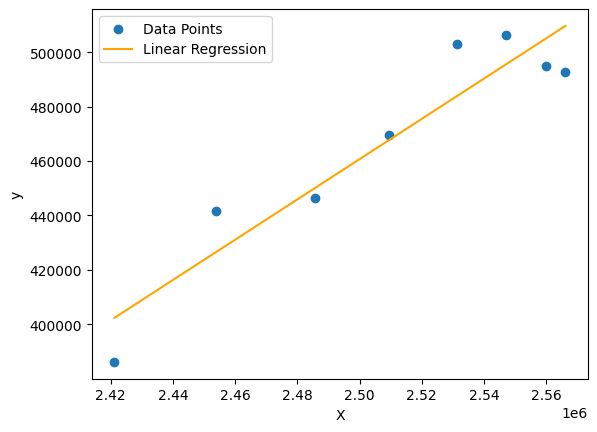

In [11]:
# correlation 2012-2019 (before COVID)
x3 = copy.deepcopy(list(x2))
y3 = copy.deepcopy(y2)
for i in range(2):
    x3.pop(8)
    y3.pop(8)

assert len(x3) == len(y3), 'Incompatiable Variables'

x3 = sm.add_constant(x3)
model3 = sm.OLS(y3, x3).fit()
y_pred3 = model3.predict(x3)

p_values3 = model3.pvalues
print(f"p-value:{p_values3}")

r23 = r2_score(y3, y_pred3)
print(f'R^2 Score: {r23}')

# Visualizing the linear regression line
plt.scatter([i[1] for i in x3], y3, label='Data Points')
plt.plot([i[1] for i in x3], y_pred3, color='orange', label='Linear Regression')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

# Regression Between Frequency and Parking Places

In [12]:
# get daily, monthly and yearly amount of the parking meters
new_meters_daily, new_meters_monthly, new_meters_yearly = defaultdict(list), defaultdict(list), defaultdict(list)
for index, row in parking_meters.iterrows():
    new_meters_daily[index].append((row['area'], row['sub_area'], row['config_id'], row['pole']))
    new_meters_monthly[(index.year, index.month)].append((row['area'], row['sub_area'], row['config_id'], row['pole']))
    new_meters_yearly[index.year].append((row['area'], row['sub_area'], row['config_id'], row['pole']))

In [13]:
# order by time
new_meters_months = sorted(list(new_meters_monthly.keys()), key=lambda item: (item[0], item[1]))

In [14]:
# path to fill out None Value
all_months = sorted(list(issue_monthly.keys()), key=lambda item: (item[0], item[1]))
start_position = all_months.index(new_meters_months[0])

In [15]:
# set variables (x as the new meters added monthly and y as the difference of the ticket amount compared to the last month)
x, y = [], []
for i in range(start_position, len(all_months)):
    x.append([len(new_meters_monthly[all_months[i]])])
    y.append(issue_monthly_amount[all_months[i]] - issue_monthly_amount[all_months[i-1]])

assert len(x) == len(y), 'Incompatiable Variables'

p-value:[3.84905780e-01 3.26577233e-04]
R^2 Score: 0.20108607923154387


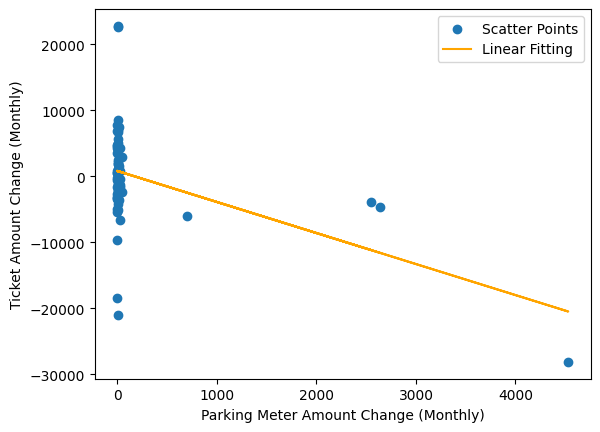

In [16]:
# corelation monthly
x = sm.add_constant(x)
model_meters = sm.OLS(y, x).fit()
y_pred = model_meters.predict(x)

p_values_meters = model_meters.pvalues
print(f"p-value:{p_values_meters}")

r2_meters = r2_score(y, y_pred)
print(f'R^2 Score: {r2_meters}')

# Visualizing the linear regression line
plt.scatter([i[1] for i in x], y, label='Scatter Points')
plt.plot([i[1] for i in x], y_pred, color='orange', label='Linear Fitting')
plt.xlabel('Parking Meter Amount Change (Monthly)')
plt.ylabel('Ticket Amount Change (Monthly)')
plt.legend()
plt.show()

In [17]:
# get the amount of the existing parking meters daily
dates = list(new_meters_daily.keys())
dates.sort()
sum, current_meters = 0, {}
for date in dates:
    sum += len(new_meters_daily[date])
    current_meters[date] = sum

In [18]:
# filter the date out of the parking meter database 
all_dates = list(issue_daily_amount.keys())
all_dates.sort()
for d in all_dates:
    if d in current_meters:
        a = all_dates.index(d)
        break
        
all_dates = sorted(list(issue_daily_amount.keys()))[a:]

In [19]:
# daily issued ticket amount
daily_parking_tickets = [issue_daily_amount[date] for date in all_dates]

In [20]:
# daily existing meter amount
daily_parking_meters = []
for date in all_dates:
    if date not in current_meters:
        daily_parking_meters.append(daily_parking_meters[-1])
    else:
        daily_parking_meters.append(current_meters[date])

In [ ]:
assert len(daily_parking_tickets) == len(daily_parking_meters), 'Incompatiable Variables'

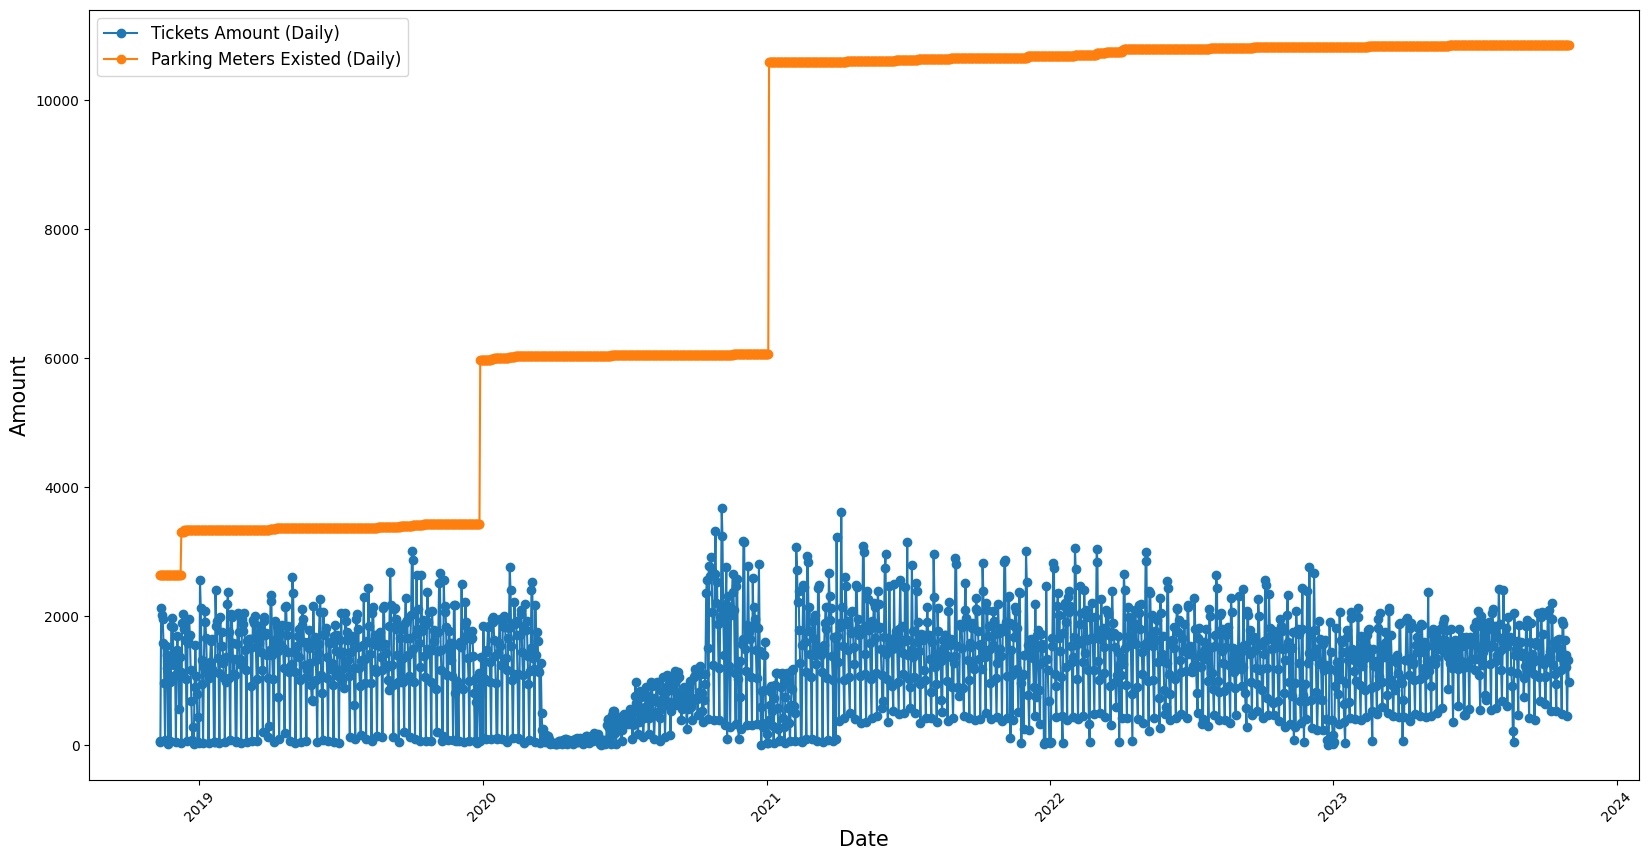

In [21]:
# visualization for correlation between existing parking meters and parking tickets
plt.figure(figsize=(20, 10), )

plt.plot(list(all_dates), np.array(daily_parking_tickets), label='Tickets Amount (Daily)', marker='o')
plt.plot(list(all_dates), np.array(daily_parking_meters), label='Parking Meters Existed (Daily)', marker='o')

plt.xlabel('Date',fontsize=15)
plt.ylabel('Amount',fontsize=15)

plt.legend(fontsize = 'large')

plt.xticks(rotation=45)

plt.show()

# Seasonal Decompose

In [22]:
# integrate dataframe as the format for seasonal decompose
df_issue_daily_amount = pd.DataFrame(list(issue_daily_amount.items()), columns=['ds', 'y'])
df_issue_daily_amount.head()

,ds,y
0,2012-06-30,753
1,2012-06-29,1079
2,2012-06-28,787
3,2012-06-27,1254
4,2012-06-26,1570


In [23]:
# treat COVID as one-off holidays
lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-21', 'lower_window': 0, 'ds_upper': '2020-06-06'},
    {'holiday': 'lockdown_2', 'ds': '2020-07-09', 'lower_window': 0, 'ds_upper': '2020-10-27'},
    {'holiday': 'lockdown_3', 'ds': '2021-02-13', 'lower_window': 0, 'ds_upper': '2021-02-17'},
    {'holiday': 'lockdown_4', 'ds': '2021-05-28', 'lower_window': 0, 'ds_upper': '2021-06-10'},
])
for t_col in ['ds', 'ds_upper']:
    lockdowns[t_col] = pd.to_datetime(lockdowns[t_col])
lockdowns['upper_window'] = (lockdowns['ds_upper'] - lockdowns['ds']).dt.days
lockdowns

,holiday,ds,lower_window,ds_upper,upper_window
0,lockdown_1,2020-03-21,0,2020-06-06,77
1,lockdown_2,2020-07-09,0,2020-10-27,110
2,lockdown_3,2021-02-13,0,2021-02-17,4
3,lockdown_4,2021-05-28,0,2021-06-10,13


In [24]:
# add COVID as additional regressor
def lockdown(ds):
    date = pd.to_datetime(ds.strftime('%Y-%m-%d'), format='%Y-%m-%d')

    lockdown_ranges = [
        pd.date_range('2020-03-21', '2020-06-06'),
        pd.date_range('2020-07-09', '2020-10-27'),
        pd.date_range('2021-02-13', '2021-02-17'),
        pd.date_range('2021-05-28', '2021-06-10')
    ]

    lockdown_ranges_set = set(date for lockdown_range in lockdown_ranges for date in lockdown_range)
    if date in lockdown_ranges_set:
        return 1
    else:
        return 0

df_issue_daily_amount['lockdowns'] = df_issue_daily_amount['ds'].apply(lockdown)
df_issue_daily_amount.head()

,ds,y,lockdowns
0,2012-06-30,753,0
1,2012-06-29,1079,0
2,2012-06-28,787,0
3,2012-06-27,1254,0
4,2012-06-26,1570,0


In [25]:
# get seasonal analysis model
model = prophet.Prophet()
model.add_regressor('lockdowns')

model.add_seasonality(name='monthly', period=30.5, fourier_order = 5)
model.add_seasonality(name='quarterly', period=91.25, fourier_order = 5)

# add holiday effect
model.add_country_holidays(country_name='US')

model.fit(df_issue_daily_amount)
future = model.make_future_dataframe(periods=365)
future['lockdowns'] = future['ds'].apply(lockdown)

forecast = model.predict(future)

result_df = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'trend', 'holidays', 'weekly','yearly', 'lockdowns']]

15:25:06 - cmdstanpy - INFO - Chain [1] start processing
15:25:06 - cmdstanpy - INFO - Chain [1] done processing


/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python date

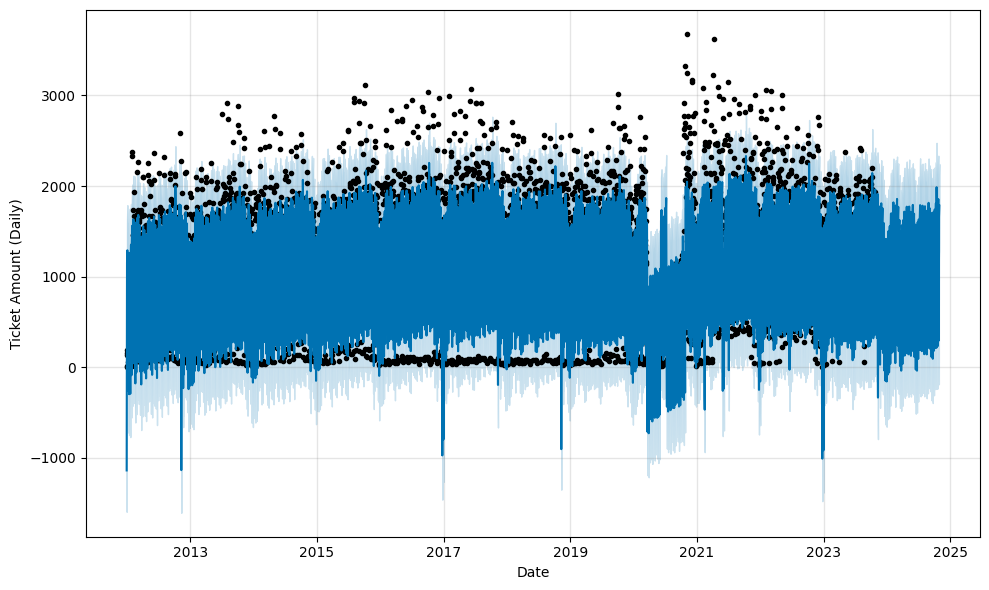

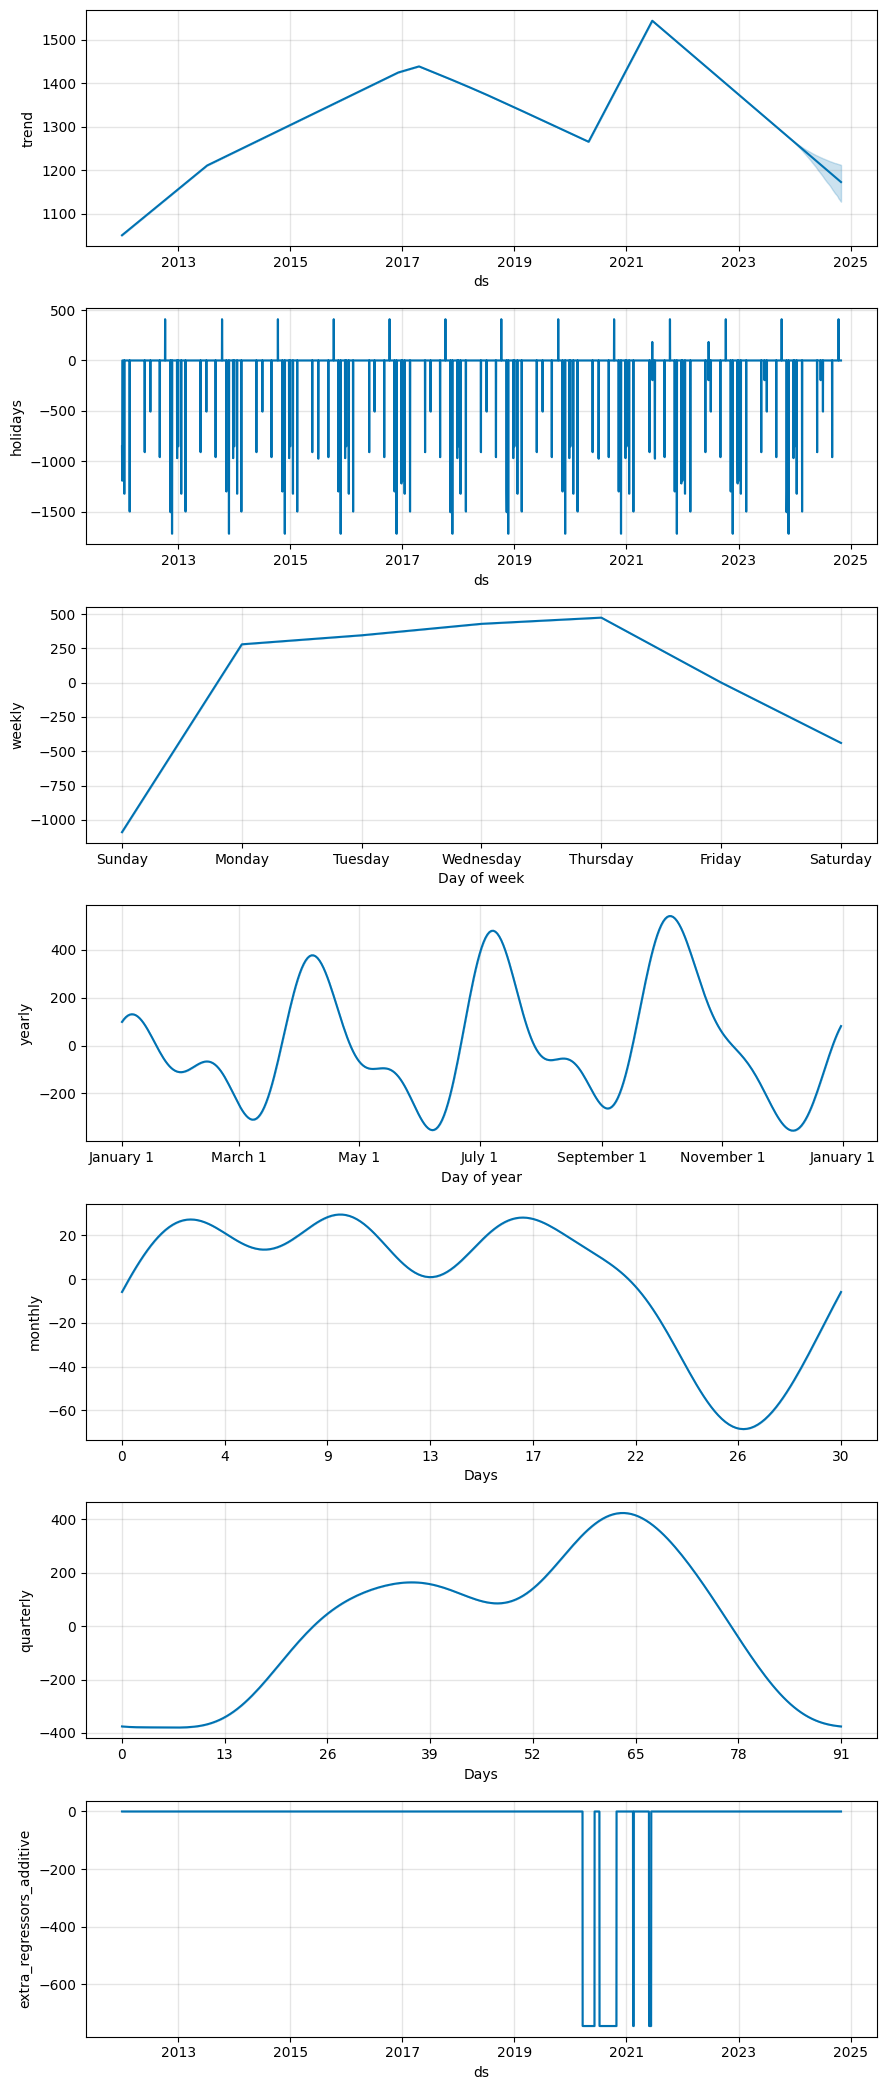

In [26]:
# get seasonal visualization
fig = model.plot(forecast, xlabel= 'Date', ylabel = 'Ticket Amount (Daily)')
fig2 = model.plot_components(forecast)

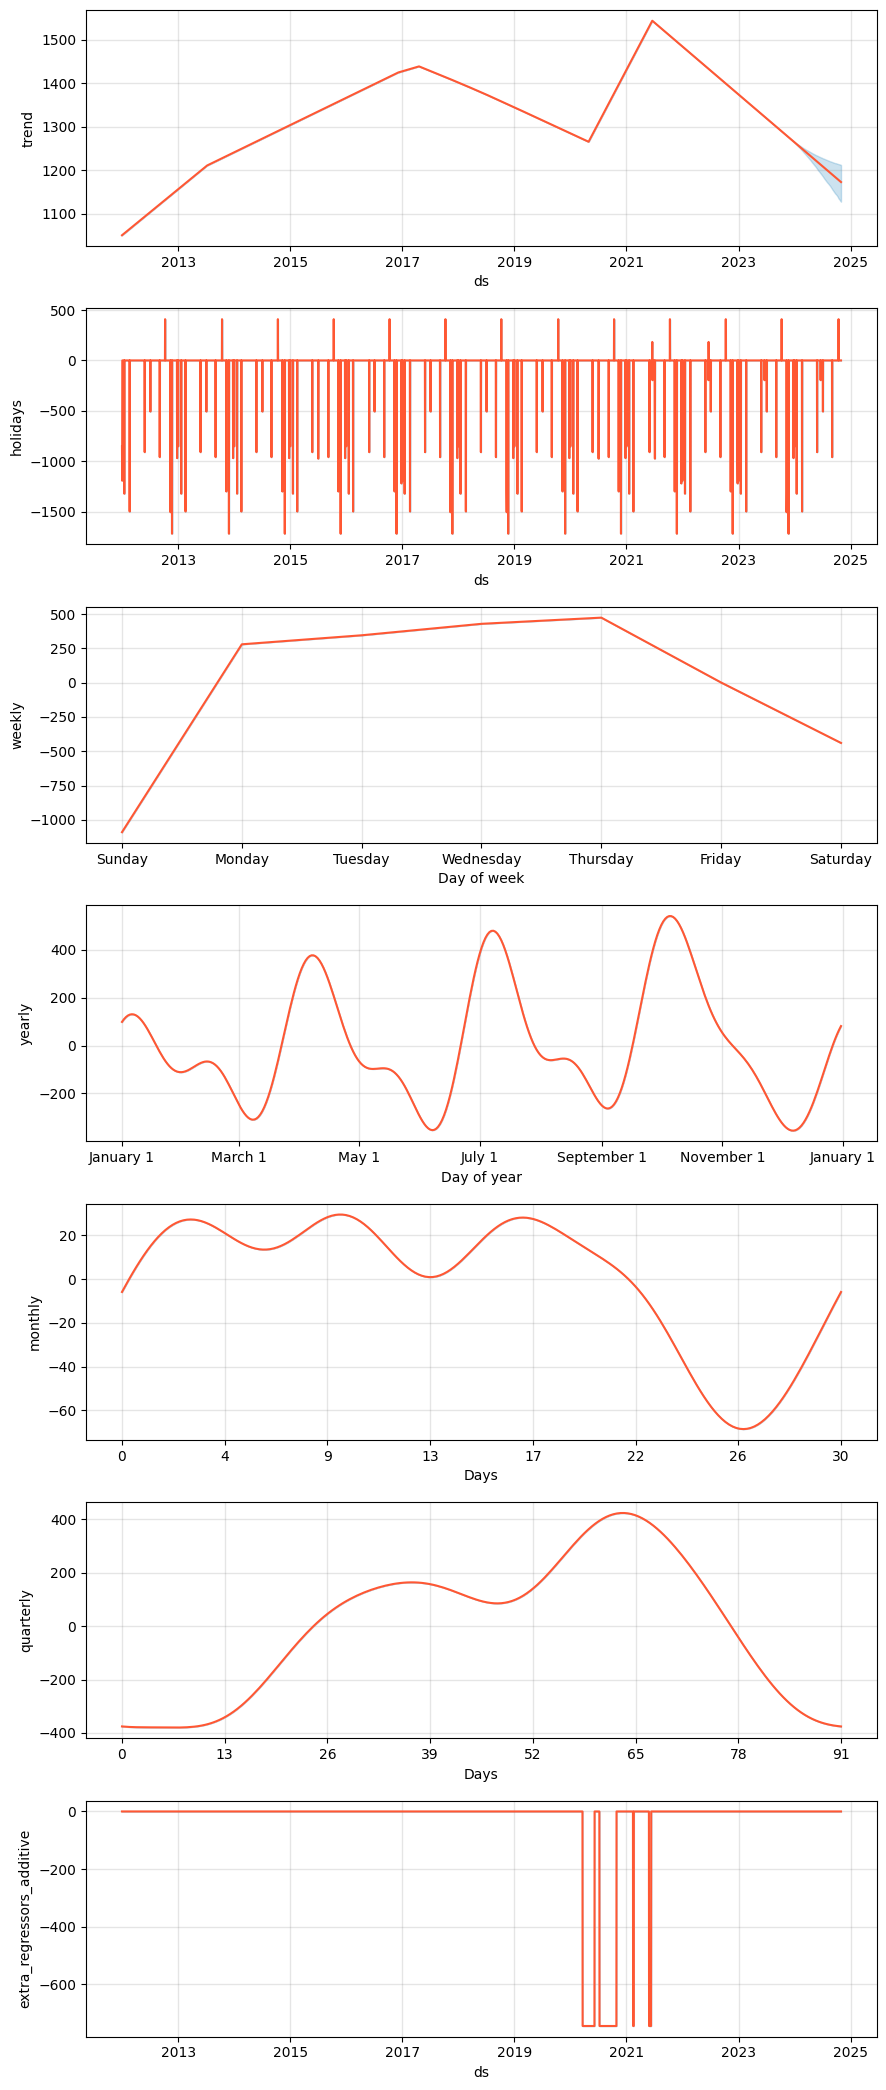

In [27]:
# amend the color
for ax in fig2.axes:
    for line in ax.lines:
        line.set_color('#FF5733')  # 替换为你想要的颜色
display(fig2)